# This notebook goes with Lesson 8, Section 18 of the Tensorflow 2.0 Course on Udacity. It is a first look at forecasting time series using Recurrent Neural Networks.

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

keras = tf.keras

The next cell is a bunch of functions that were written in previous notebooks from this lesson. After that, we create the simulated time series, then split it into Training and Test sets. Check the other notebooks if you are interested in more information.

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
    
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

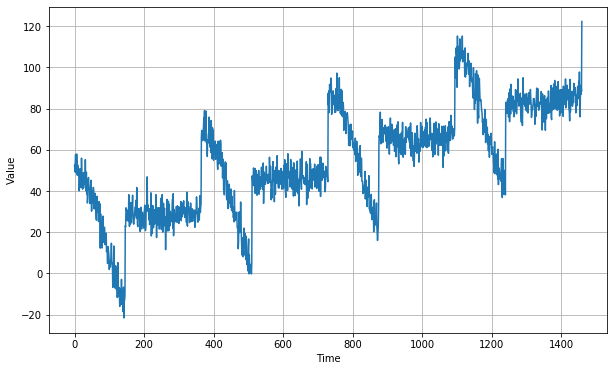

In [7]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## First RNN forecast

The big new thing in this, at least in terms of programming the model, is that RNNs take a 3-dimensional input. The dimensions are:

* Batch Size
* Number of Time Steps
* Number of features

We only have a 2 dimensions for our time series...so we need to expand the dimensions of the input using **tf.expand_dims**, which we do in a Lambda layer in the following cell.

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                       input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 **(epoch/20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 21ms/step - loss: 50.2174 - mae: 50.7172
Epoch 2/100
8/8 [==============================] - 0s 20ms/step - loss: 23.0010 - mae: 23.4934
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 19.2075 - mae: 19.7005
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 16.9702 - mae: 17.4606
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 15.4094 - mae: 15.8988
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 14.7507 - mae: 15.2367
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 14.3058 - mae: 14.7931
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 14.0615 - mae: 14.5512
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 13.7812 - mae: 14.2687
Epoch 10/100
8/8 [==============================] - 0s 17ms/step - loss: 13.5641 - mae: 14.0522
Epoch 11/100
8/8 [==============================]

[1e-07, 0.0001, 0, 30]

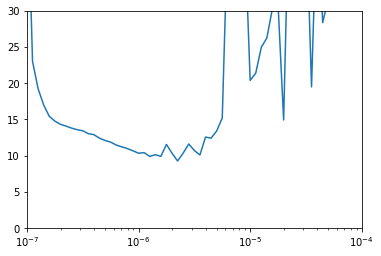

In [19]:
plt.semilogx(history.history["lr"], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

The best leraning rate is somewhere a little under $10^{-6}$, before the loss rate starts activing crazy and goes back up. Let's make this good model then.

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                       input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)

model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint",
                                                  save_best_only=True)

model.fit(train_set, epochs=500, validation_data = valid_set,
          callbacks = [early_stopping, model_checkpoint])


Epoch 1/500
      7/Unknown - 0s 18ms/step - loss: 57.3398 - mae: 57.8383WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 3s 371ms/step - loss: 54.8861 - mae: 55.3848 - val_loss: 53.7722 - val_mae: 54.2722
Epoch 2/500
8/8 [==============================] - 3s 335ms/step - loss: 35.4594 - mae: 35.9563 - val_loss: 17.5198 - val_mae: 18.0160
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 22.5446 - mae: 23.0386 - val_loss: 18.8164 - val_mae: 19.3133
Epoch 4

In [22]:
model = keras.models.load_model("my_checkpoint")

In [23]:
rnn_forecast = model_forecast(model,
                             series[split_time - window_size:-1],
                             window_size)[:,0]

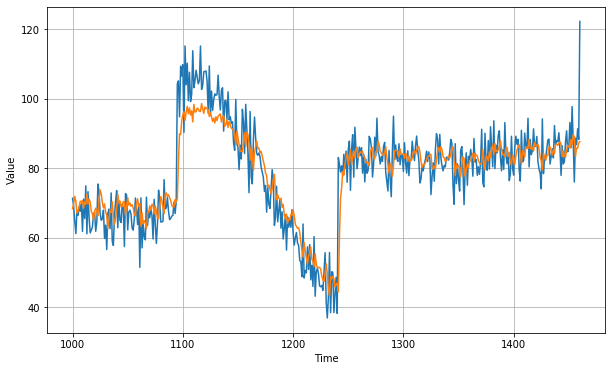

In [24]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3282285

Not bad. It catches quite a bit of the behavior of the time series, but actually didn't do as well as our previous models. Let's try a new kind of forecasting to see if we can do better!

## Sequence-to-Sequence Forecasting

Above, we used a model with a couple of RNN layers to predict new values one step at a time. What we can going to do now is use those same RNN layers to predict an entire sequence, then use the end of that sequence as the prediction for the next time step. It's kind of like smoothing, I guess. 

Also, since we need to change our input series into the appropriate form, we can change the dimensionality in the next cell rather than in Lambda layers like we did before.

In [26]:
def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

What does this weird-looking function do? Let's test it out on the series $[1,2,...10]$ in the next cell. It breaks the series into X and Y vectors of length(window_size), such as:
$$X_1 = [1,2,3] \implies Y_1 = [2,3,4]$$

So we are using the previous few values to predict the next few values, with some overlap.

In [27]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3, batch_size=1):
    print("X: ", X_batch.numpy())
    print("Y: ", Y_batch.numpy())

X:  [[[1]
  [2]
  [3]]]
Y:  [[[2]
  [3]
  [4]]]
X:  [[[2]
  [3]
  [4]]]
Y:  [[[3]
  [4]
  [5]]]
X:  [[[4]
  [5]
  [6]]]
Y:  [[[5]
  [6]
  [7]]]
X:  [[[3]
  [4]
  [5]]]
Y:  [[[4]
  [5]
  [6]]]
X:  [[[5]
  [6]
  [7]]]
Y:  [[[6]
  [7]
  [8]]]
X:  [[[6]
  [7]
  [8]]]
Y:  [[[7]
  [8]
  [9]]]
X:  [[[0]
  [1]
  [2]]]
Y:  [[[1]
  [2]
  [3]]]


Now let's build a forecasting model using this idea. Notice how we now need both RNN layers to return sequences.

In [28]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,
                          input_shape = [None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 **(epoch/30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)

model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 0s 20ms/step - loss: 52.3619 - mae: 52.8615
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 25.4714 - mae: 25.9672
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 23.5030 - mae: 23.9972
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 21.1368 - mae: 21.6294
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 19.4762 - mae: 19.9674
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 18.6742 - mae: 19.1647
Epoch 7/100
8/8 [==============================] - 0s 19ms/step - loss: 18.1698 - mae: 18.6587
Epoch 8/100
8/8 [==============================] - 0s 19ms/step - loss: 17.7679 - mae: 18.2568
Epoch 9/100
8/8 [==============================] - 0s 19ms/step - loss: 17.4389 - mae: 17.9280
Epoch 10/100
8/8 [==============================] - 0s 18ms/step - loss: 17.0989 - mae: 17.5875
Epoch 11/100
8/8 [==============================]

[1e-07, 0.0001, 0, 30]

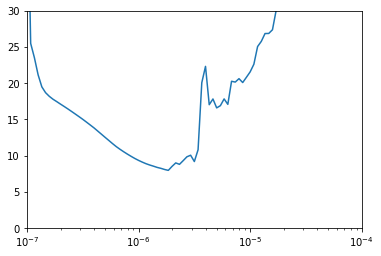

In [29]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-4, 0, 30])

Very interesting. It doesn't go quite as crazy as last time. The best learning rate, it seems, is somewhere around $10^{-6}$. Let's build the best learning-rate model and train it plentifully and see how it does.

In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True,
                          input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=10)

model.fit(train_set, epochs=500, validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 0s 60ms/step - loss: 54.1430 - mae: 54.6414 - val_loss: 17.9208 - val_mae: 18.4156
Epoch 2/500
8/8 [==============================] - 0s 31ms/step - loss: 34.1722 - mae: 34.6695 - val_loss: 20.5483 - val_mae: 21.0442
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 27.5075 - mae: 28.0027 - val_loss: 37.8714 - val_mae: 38.3709
Epoch 4/500
8/8 [==============================] - 0s 31ms/step - loss: 21.0647 - mae: 21.5579 - val_loss: 25.2686 - val_mae: 25.7676
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3557 - val_mae: 15.8506
Epoch 6/500
8/8 [==============================] - 0s 31ms/step - loss: 15.0383 - mae: 15.5247 - val_loss: 9.4218 - val_mae: 9.9071
Epoch 7/500
8/8 [==============================] - 0s 32ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6474
Epoch 8/500
8/8 [==============================] - 0s 33ms/step - 

In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

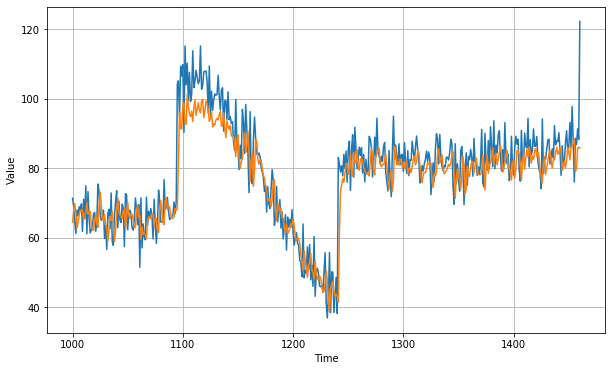

In [32]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [34]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.458875

That looks pretty nice, actually, doesn't it? Even though the forecast did not quite go all the way up to where the time series did...

Well, there you go. Two different ways of forecasting using Recurrent Neural Networks. Would this be useful for predicting stock prices? Maybe. We should try that! That would be excellent.